In [3]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from skimage.io import imread
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation, GaussianNoise
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.constraints import maxnorm

## Загрузка набора данных и предварительный анализ

In [4]:
def draw_pictures(img_df):
    n = len(img_df)
    cols = 5
    if n < cols:
        cols = n
    rows = n//cols+1 if (n/cols > n//cols) else n//cols
    plt.subplots(squeeze=False, figsize=(10,10))
    for i in range(n):
        plt.subplot2grid((rows, cols), (i//cols, i%cols)).imshow(imread(df['path'][i]))

In [5]:
def draw_image_hist(img_path):
    image = imread(img_path)
    plt.hist(image.ravel(), bins = 256, color = 'orange')
    plt.hist(image[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
    plt.hist(image[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
    plt.hist(image[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
    plt.xlabel('Интенсивность')
    plt.ylabel('Количество')
    plt.legend(['Общая', 'Красный канал', 'Зелёный канал', 'Синий канал'])
  

In [6]:
def draw_pictures_with_hists(img_df):
    n = len(img_df)
    cols = 5
    if n < cols:
        cols = n
    rows = n//cols+1 if (n/cols > n//cols) else n//cols
    fig, axes = plt.subplots(rows*2, cols, figsize=(cols*5,rows*10))
    plt.suptitle('Цветовая гистограмма')
    row_i =0
    for i in range(n):
        image = imread(df['path'][i])
        axes[row_i, i%cols].hist(image.ravel(), bins = 256, color = 'orange', )
        axes[row_i, i%cols].hist(image[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
        axes[row_i, i%cols].hist(image[:, :, 1].ravel(), bins = 256, color = 'green', alpha = 0.5)
        axes[row_i, i%cols].hist(image[:, :, 2].ravel(), bins = 256, color = 'blue', alpha = 0.5)
        axes[row_i, i%cols].legend(['Общая', 'Красный канал', 'Зелёный канал', 'Синий канал'])
        axes[row_i, i%cols].set_xlabel('Интенсивность')
        axes[row_i, i%cols].set_ylabel('Количество')
        axes[row_i+1, i%cols].imshow(image)
        if (i%cols+1 == cols):
            row_i += 2

        

In [7]:
image_path = "../data/Raw/"
image_files = []
global classes_dict 
classes_dict = {}
for k, dir in enumerate(os.listdir(image_path)):
    classes_dict[dir.lower()] = k
    image_files.extend(os.path.join(image_path, dir, file) for file in os.listdir(os.path.join(image_path, dir)) if file.endswith(('.JPG', '.jpg')))

In [8]:
for class_title, class_number in classes_dict.items():
    print (f"Класс: \033[1m{class_title}\033[0m - номер {class_number}")

Класс: bottle_opener - номер 0
Класс: can_opener - номер 1
Класс: dinner_fork - номер 2
Класс: fish_slice - номер 3
Класс: kitchen_knife - номер 4
Класс: masher - номер 5
Класс: peeler - номер 6
Класс: pizza_cutter - номер 7
Класс: tongs - номер 8
Класс: whisk - номер 9


In [22]:
def img_params(img_path):
    img = imread(img_path) 
    img_class = img_path.replace(image_path, '').split('\\')[0].lower()
    return classes_dict[img_class], img_path, img.shape[0], img.shape[1], img.shape[2], img.max(), img.min(), img.mean(), img.std(), np.median(img)

In [23]:
images_data = np.array(list(map(img_params, np.asarray(image_files))))

In [29]:
df = pd.DataFrame(columns=['img_class','path','height', 'width', 'dimension', 'max_rgb', 'min_rgb', 'mean_rgb', 'std_rgb', 'median_rgb'], data=images_data)
df = df.astype({'height': 'int32', 'width': 'int32', 'dimension': 'int32', 'max_rgb': 'float32',
          'min_rgb': 'float32', 'mean_rgb': 'float32', 'std_rgb': 'float32', 'median_rgb': 'float32'})


img_class - класс, к которому относится изображение

path - путь к файлу изображения

height - высота изображения

width - ширина изображения

dimension - количество цветовых каналов изображения

max_rgb - максимальное значение пикселя в изображении

min_rgb - минимальное значение пикселя в изображении

mean_rgb - среднее значение пикселя в изображении

std_rgb  - стандартное отклонение значения пикселя в изображении



In [30]:
print('Первые 5 строчек датасета:')
df.head()

Первые 5 строчек датасета:


,img_class,path,height,width,dimension,max_rgb,min_rgb,mean_rgb,std_rgb,median_rgb
0,0,../data/Raw/BOTTLE_OPENER\bottleopenerraw1.JPG,1536,2048,3,255.0,0.0,54.986946,34.352425,47.0
1,0,../data/Raw/BOTTLE_OPENER\bottleopenerraw10.JPG,1536,2048,3,255.0,0.0,138.947037,68.768059,157.0
2,0,../data/Raw/BOTTLE_OPENER\bottleopenerraw11.JPG,1536,2048,3,255.0,0.0,145.557602,69.073090,166.0
3,0,../data/Raw/BOTTLE_OPENER\bottleopenerraw12.JPG,1536,2048,3,255.0,0.0,129.254044,68.981476,145.0
4,0,../data/Raw/BOTTLE_OPENER\bottleopenerraw13.JPG,1536,2048,3,255.0,0.0,132.945312,62.024948,143.0


Первые 5 изображений датасета:


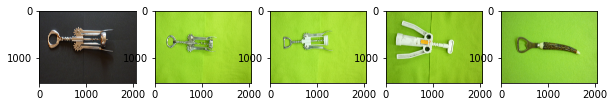

In [26]:
print('Первые 5 изображений датасета:')
draw_pictures(df[:5])

In [31]:
print(f'Количество фотографий в датасете: {df.shape[0]}')
print('Количество отсутствующих значений в датасете и типы данных по столбцам:\n')
print(df.info())

Количество фотографий в датасете: 384
Количество отсутствующих значений в датасете и типы данных по столбцам:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 384 entries, 0 to 383
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   img_class   384 non-null    object 
 1   path        384 non-null    object 
 2   height      384 non-null    int32  
 3   width       384 non-null    int32  
 4   dimension   384 non-null    int32  
 5   max_rgb     384 non-null    float32
 6   min_rgb     384 non-null    float32
 7   mean_rgb    384 non-null    float32
 8   std_rgb     384 non-null    float32
 9   median_rgb  384 non-null    float32
dtypes: float32(5), int32(3), object(2)
memory usage: 18.1+ KB
None


## Описательный анализ данных

Описание численных типов данных

In [32]:
df.describe()

,height,width,dimension,max_rgb,min_rgb,mean_rgb,std_rgb,median_rgb
count,384.000000,384.000000,384.0,384.000000,384.000000,384.000000,384.000000,384.000000
mean,1919.877604,2196.020833,3.0,252.078125,0.554688,114.785240,59.362621,122.236977
std,1124.413861,1065.734981,0.0,10.093513,3.569837,40.792526,13.148533,53.284092
min,131.000000,169.000000,3.0,172.000000,0.000000,31.535715,20.020618,17.000000
25%,1536.000000,2048.000000,3.0,255.000000,0.000000,90.142014,55.076073,81.500000
50%,1536.000000,2048.000000,3.0,255.000000,0.000000,107.534512,61.456266,128.000000
75%,2322.000000,2322.000000,3.0,255.000000,0.000000,127.188507,67.557903,147.000000
max,4128.000000,4128.000000,3.0,255.000000,44.000000,247.524033,100.123886,255.000000


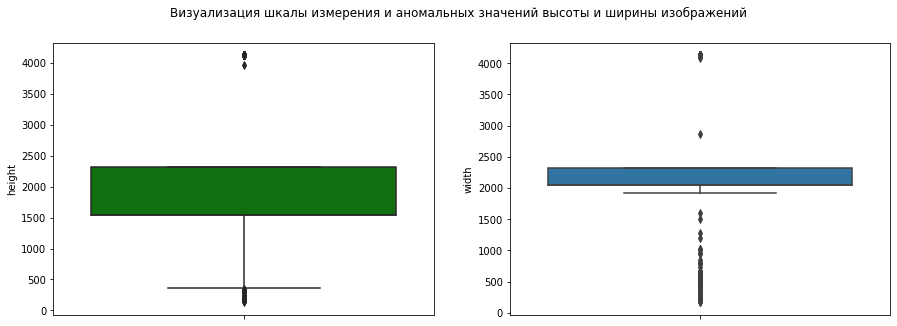

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Визуализация шкалы измерения и аномальных значений высоты и ширины изображений')
sns.boxplot(ax=axes[0], y="height", data=df, color='green')
sns.boxplot(ax=axes[1], y="width", data=df)
plt.show()

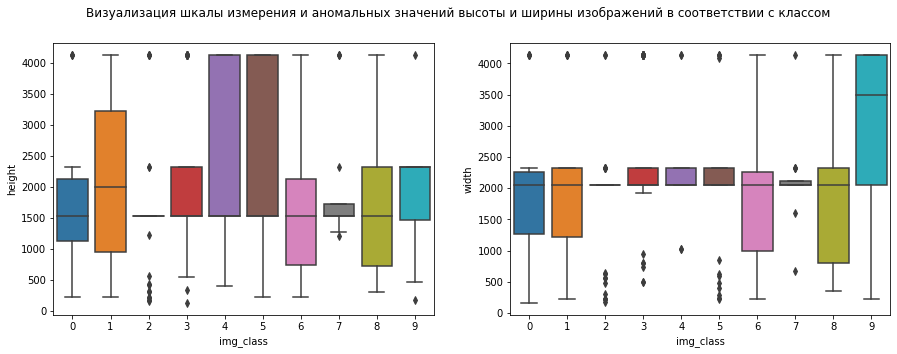

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Визуализация шкалы измерения и аномальных значений высоты и ширины изображений в соответствии с классом')
sns.boxplot(ax=axes[0], x="img_class", y="height", data=df)
sns.boxplot(ax=axes[1], x="img_class", y="width", data=df)
plt.show()

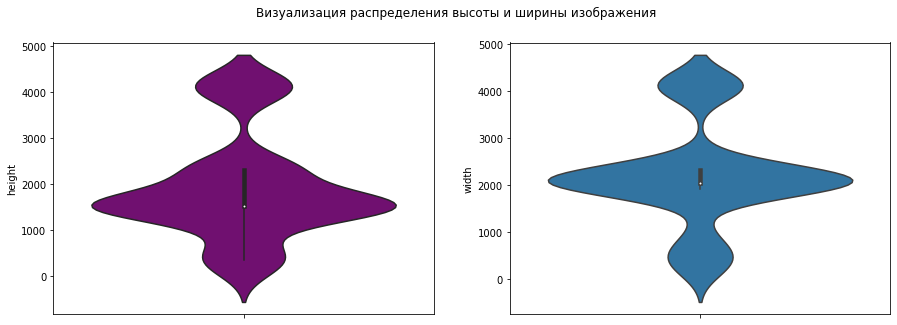

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Визуализация распределения высоты и ширины изображения ')
sns.violinplot(ax=axes[0], y = df['height'], color='purple')
sns.violinplot(ax=axes[1], y = df['width'])
plt.show()

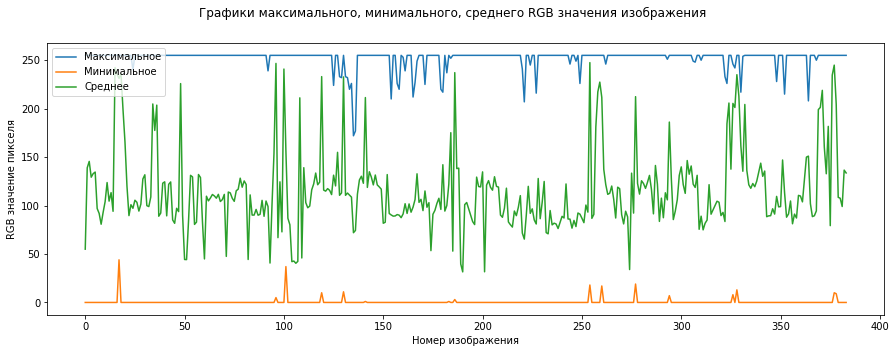

In [45]:
f, ax = plt.subplots(figsize=(15, 5))
f.suptitle('Графики максимального, минимального, среднего RGB значения изображения')
sns.lineplot(label='Максимальное', data=df['max_rgb'])
sns.lineplot(label='Минимальное', data=df['min_rgb'])
sns.lineplot(label='Среднее', data=df['mean_rgb'])
plt.legend(fontsize=10, loc='upper left')
plt.xlabel('Номер изображения')
plt.ylabel('RGB значение пикселя')
plt.show()

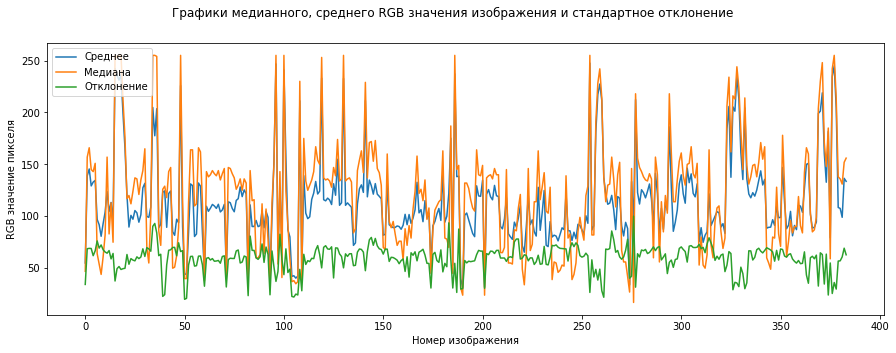

In [48]:
f, ax = plt.subplots(figsize=(15, 5))
f.suptitle('Графики медианного, среднего RGB значения изображения и стандартное отклонение')
sns.lineplot(label='Среднее', data=df['mean_rgb'])
sns.lineplot(label='Медиана', data=df['median_rgb'])
sns.lineplot(label='Отклонение', data=df['std_rgb'])
plt.legend(fontsize=10, loc='upper left')
plt.xlabel('Номер изображения')
plt.ylabel('RGB значение пикселя')
plt.show()

Описание категориальных типов данных

In [49]:
df.describe(include = ['O'])

,img_class,path
count,384,384
unique,10,384
top,3,../data/Raw/BOTTLE_OPENER\bottleopenerraw1.JPG
freq,82,1


In [50]:
for class_title, class_number in classes_dict.items():
    print (f"Класс номер {class_number} {class_title}: {len(df[df['img_class'] == str(class_number)])} ({len(df[df['img_class'] == str(class_number)])/len(df)*100:.2f}%)")
print (f"Всего: {len(df)}")

Класс номер 0 bottle_opener: 30 (7.81%)
Класс номер 1 can_opener: 19 (4.95%)
Класс номер 2 dinner_fork: 59 (15.36%)
Класс номер 3 fish_slice: 82 (21.35%)
Класс номер 4 kitchen_knife: 41 (10.68%)
Класс номер 5 masher: 38 (9.90%)
Класс номер 6 peeler: 18 (4.69%)
Класс номер 7 pizza_cutter: 16 (4.17%)
Класс номер 8 tongs: 37 (9.64%)
Класс номер 9 whisk: 44 (11.46%)
Всего: 384


Цветовые гистограммы по трём каналам

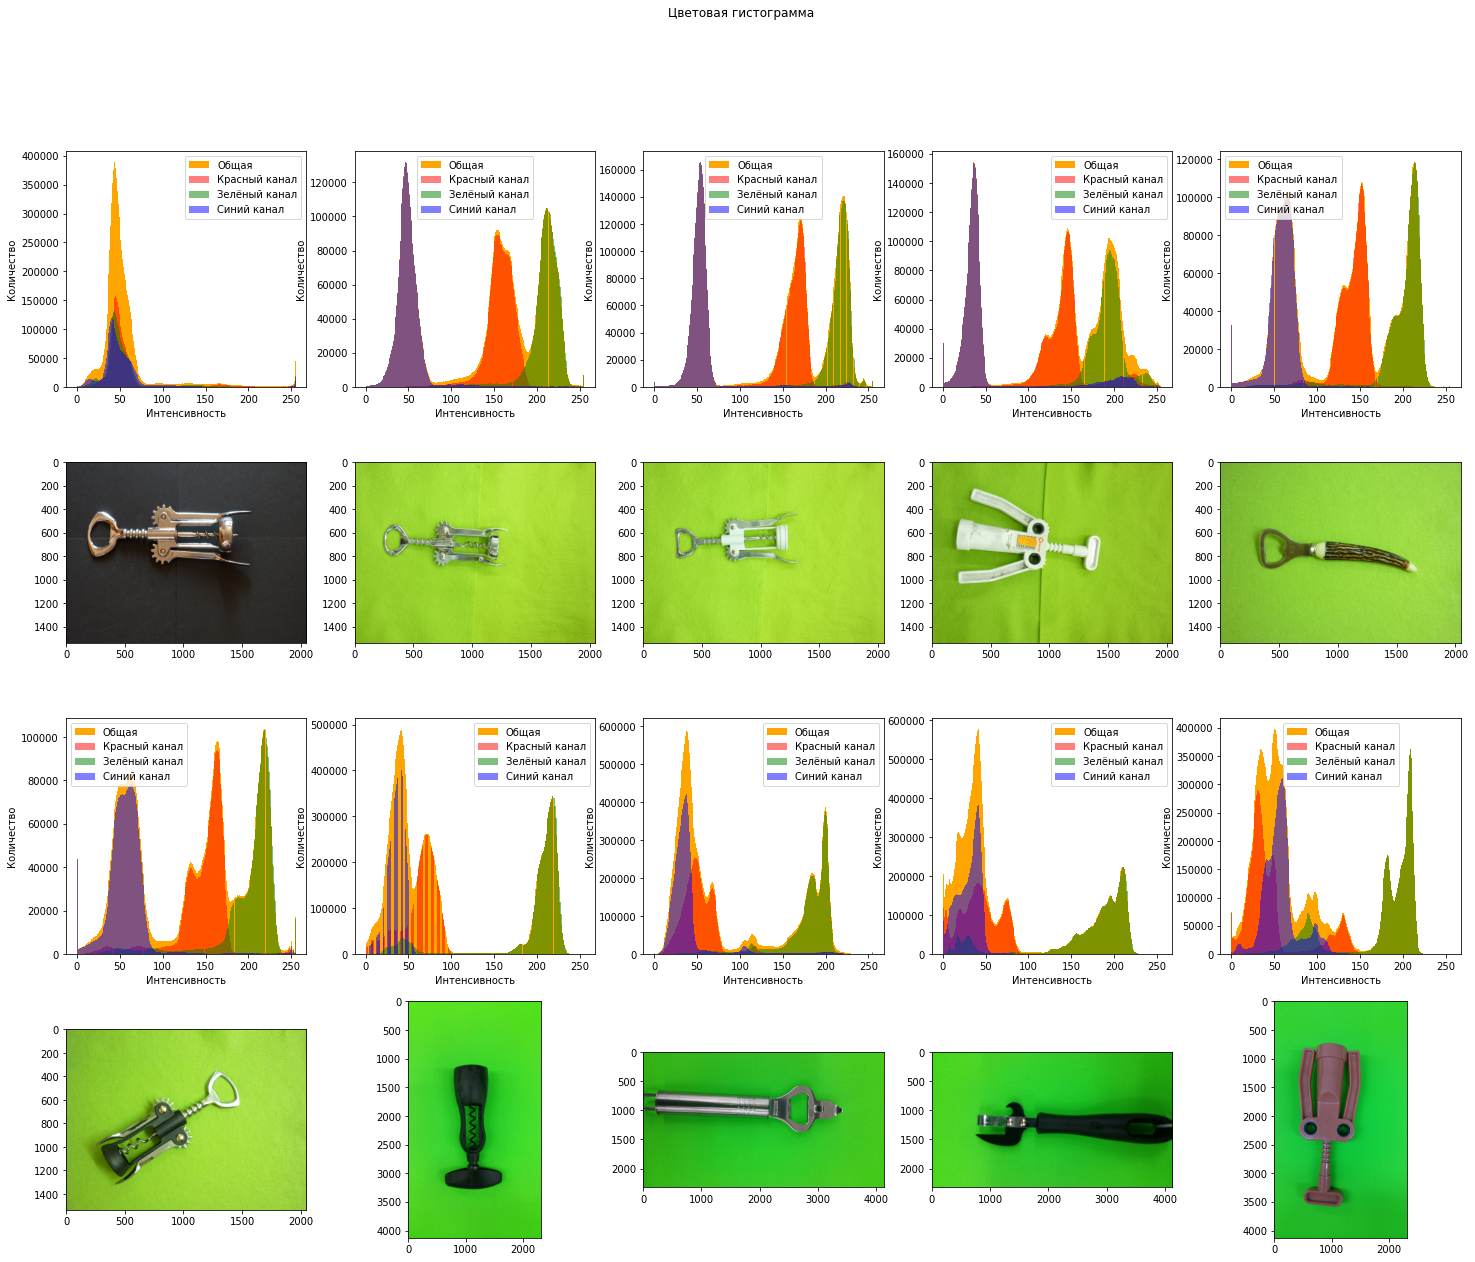

In [52]:
draw_pictures_with_hists(df[:10])

Корреляционная матрица датасета


<AxesSubplot:>

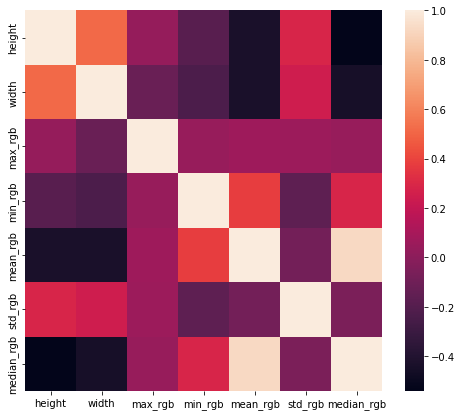

In [53]:
print("Корреляционная матрица датасета")
plt.rcParams['figure.figsize'] = (8,7)
sns.heatmap(df.drop('dimension', axis=1).corr())

Таблица рассеивания классов фотографий от всех факторов


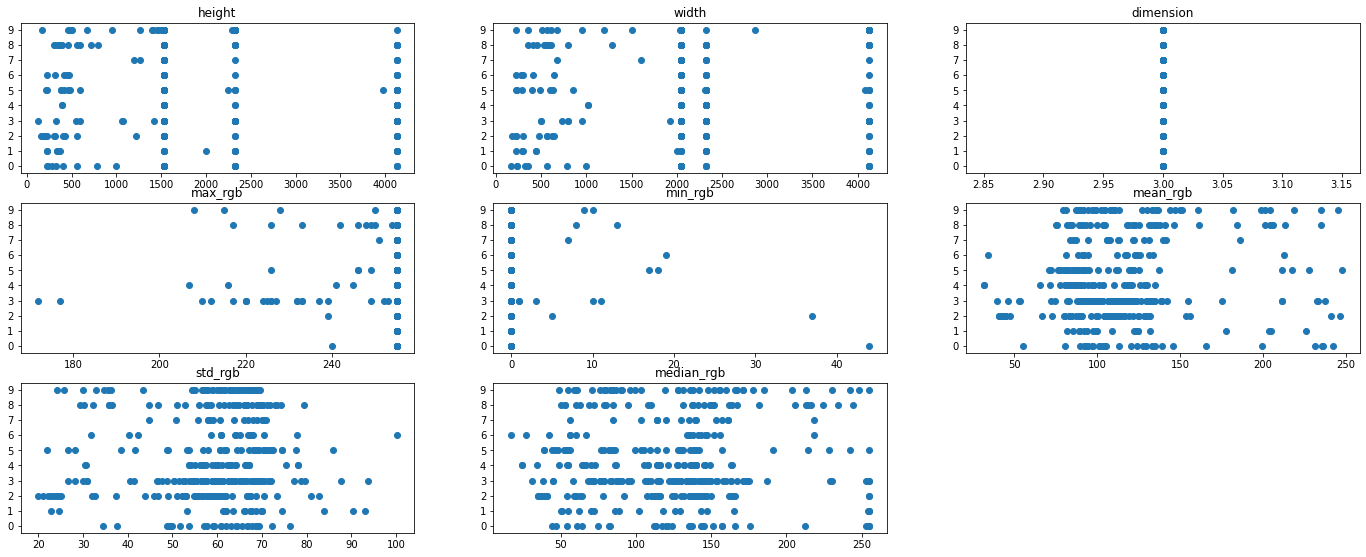

In [54]:
print('Таблица рассеивания классов фотографий от всех факторов')
plt.rcParams['figure.figsize'] = (24,16)
for i, col in enumerate(df.columns[2:]):
    plt.subplot(5, 3, i+1)
    plt.scatter(df[col], df['img_class'])
    plt.title(col)

Добавление 

In [189]:
seed = 21
rotation = 45
datagen = ImageDataGenerator(rotation_range=rotation, 
                             width_shift_range=0.2, 
                             height_shift_range=0.2, 
                             shear_range=0.2, 
                             zoom_range=0.3, 
                             horizontal_flip=True, 
                             vertical_flip=True, 
                             fill_mode="nearest")
for label in classes_dict.keys():
    res1 = datagen.flow_from_directory(image_path,
                                       batch_size=1,
                                       seed=seed,
                                       class_mode='categorical',
                                       save_to_dir=image_path + label,
                                       classes=[label],
                                       save_prefix=f"new_{label}",
                                       save_format="jpeg")

    n_augmentations = len(res1)*round((360/rotation))
    for _ in range(n_augmentations):
        next(res1)


Found 30 images belonging to 1 classes.
Found 19 images belonging to 1 classes.
Found 59 images belonging to 1 classes.
Found 82 images belonging to 1 classes.
Found 41 images belonging to 1 classes.
Found 39 images belonging to 1 classes.
Found 19 images belonging to 1 classes.
Found 17 images belonging to 1 classes.
Found 38 images belonging to 1 classes.
Found 45 images belonging to 1 classes.


## Моделирование

In [209]:
img_path = "../data/Raw/"
img_width = 128
img_height = 128
batch_size = 128
datagen = ImageDataGenerator(
    rescale=1. / 255., 
    samplewise_center=True,
    samplewise_std_normalization=True,
    validation_split=0.3)
train_generator = datagen.flow_from_directory(img_path, 
                                    subset='training',
                                    target_size=(img_height, img_width), 
                                    batch_size=batch_size, 
                                    shuffle=False, 
                                    class_mode='categorical', 
                                    color_mode='rgb')
test_generator = datagen.flow_from_directory(img_path, 
                                    subset='validation',
                                    target_size=(img_height, img_width), 
                                    batch_size=batch_size, 
                                    shuffle=False, 
                                    class_mode='categorical', 
                                    color_mode='rgb')


Found 2455 images belonging to 10 classes.
Found 1046 images belonging to 10 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


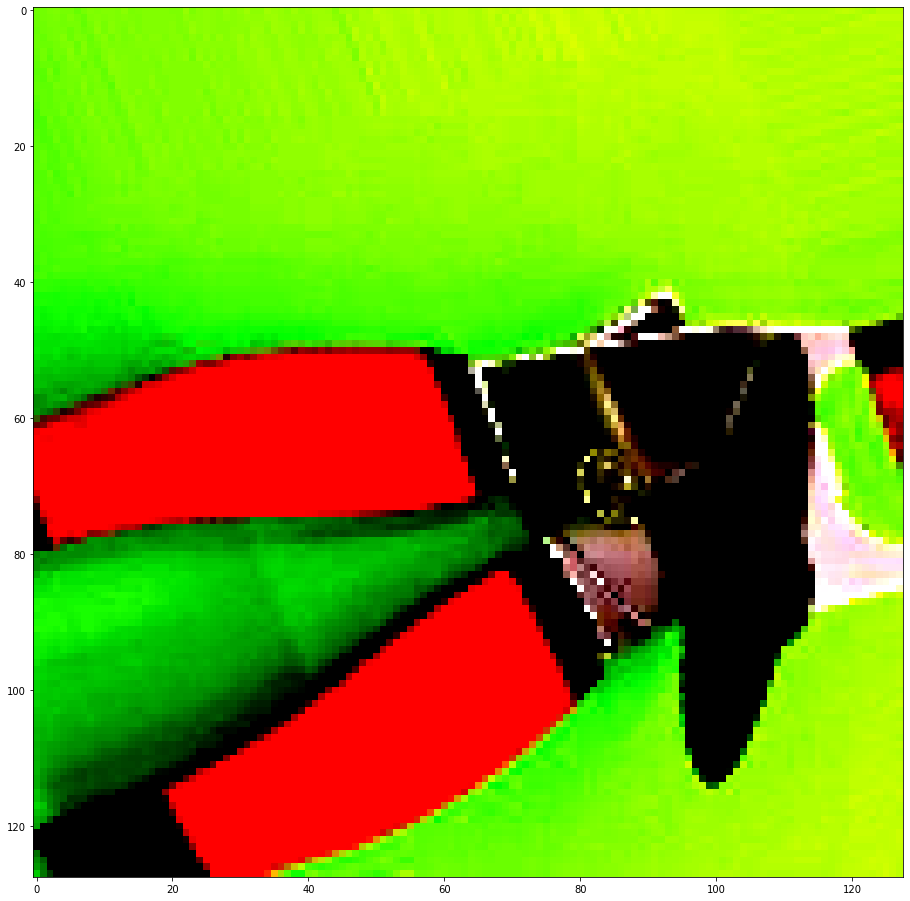

In [210]:
plt.imshow(train_generator[2][0][0])

In [211]:
class_num = train_generator.num_classes

Модель

In [212]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=train_generator[0][0].shape[1:], padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(256, kernel_constraint=maxnorm(3), activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(128, kernel_constraint=maxnorm(3), activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(class_num))
model.add(Activation('softmax'))

In [213]:
epochs = 1
optimizer = 'adam'
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
np.random.seed(seed)
history = model.fit(train_generator, epochs=epochs)

20/20 [==============================] - 242s 12s/step - loss: 2.8117 - accuracy: 0.0868


Оценка качества

In [8]:
scores = model.evaluate(test_generator, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 11.03%


In [9]:
scores

[3.1156322956085205, 0.11026615649461746]